# Importing libraries :

In [1]:
import gc
import os
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from IPython.core.display import display, HTML

from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')



# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
#from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
#import catboost as cb

# Reading Data :

In [2]:
%%time
#https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading
df_train = pd.read_feather('../input/preprocessing-and-feature-engineering/new_train.feather')
df_weather_train = pd.read_feather('../input/preprocessing-and-feature-engineering/new_weather_train.feather')
df_building = pd.read_feather('../input/preprocessing-and-feature-engineering/new_building_metadata.feather')

CPU times: user 228 ms, sys: 545 ms, total: 772 ms
Wall time: 708 ms


# Memory Reduction :

In [3]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def memory_reduction(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'
          .format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def create_X_y(target_train_df, target_meter):
    # This function divides dataframe to X_train and y_train
    target_train_df = target_train_df.merge(df_building, on='building_id', how='left')
    target_train_df = target_train_df.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')
    target_train_df = target_train_df.dropna()
    #X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values
    X_train = target_train_df.drop(['meter_reading_log1p'],axis = 1)
    del target_train_df
    return X_train, y_train


In [5]:
target_meter = 0
X_train, y_train = create_X_y(df_train, target_meter=target_meter)
gc.collect()
print('target_meter', target_meter, X_train.shape)


target_meter 0 (18231121, 24)


In [6]:
X_train = X_train.drop(['meter_reading','index','timestamp'],axis = 1) 

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18231121 entries, 0 to 18323526
Data columns (total 21 columns):
 #   Column              Dtype   
---  ------              -----   
 0   building_id         int16   
 1   meter               int8    
 2   day                 int16   
 3   hour                int8    
 4   weekend             int8    
 5   month               int8    
 6   dayofweek           int8    
 7   building_mean       float32 
 8   site_id             int8    
 9   primary_use         category
 10  square_feet         int32   
 11  year_built          float32 
 12  floor_count         float32 
 13  air_temperature     float32 
 14  cloud_coverage      float32 
 15  dew_temperature     float32 
 16  precip_depth_1_hr   float32 
 17  sea_level_pressure  float32 
 18  wind_direction      float32 
 19  wind_speed          float32 
 20  IsHoliday           float64 
dtypes: category(1), float32(10), float64(1), int16(2), int32(1), int8(6)
memory usage: 1.2 GB


# Adding few features :

In [8]:
#https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124984
#horizsolar is supposed to calculate the solar horizontal radiation coming into the building.
latitude_dict = {0 :28.5383,1 :50.9097,2 :33.4255,3 :38.9072,4 :37.8715,5 :50.9097,6 :40.7128,7 :45.4215,8 :28.5383,9 :30.2672,10 :40.10677,11 :45.4215,12 :53.3498,13 :44.9375,14 :38.0293,15: 40.7128,}

X_train['latitude'] = X_train['site_id'].map(latitude_dict)
X_train['solarHour'] = (X_train['hour']-12)*15 # to be removed
X_train['solarDec'] = -23.45*np.cos(np.deg2rad(360*(X_train['day']+10)/365)) # to be removed
X_train['horizsolar'] = np.cos(np.deg2rad(X_train['solarHour']))*np.cos(np.deg2rad(X_train['solarDec']))*np.cos(np.deg2rad(X_train['latitude'])) + np.sin(np.deg2rad(X_train['solarDec']))*np.sin(np.deg2rad(X_train['latitude']))
X_train['horizsolar'] = X_train['horizsolar'].apply(lambda x: 0 if x <0 else x)

In [9]:
X_train = X_train.drop(['latitude','solarHour','solarDec'], axis=1)

In [10]:
# The sensible heat is a form of energy emitted into the atmosphere or absorbed
X_train['Sensible_Heat'] = 0.5274*(10.**(-4.))*X_train['square_feet']*(75.-X_train['air_temperature'])


https://bmcnoldy.rsmas.miami.edu/Humidity.html

#### RH: =100*(EXP((17.625*TD)/(243.04+TD))/EXP((17.625*T)/(243.04+T)))

In [11]:
X_train['relative_humidity'] = 100 * (np.exp((17.625 * X_train['dew_temperature']) / (243.04 + X_train['dew_temperature'])) / np.exp((17.625 * X_train['air_temperature'])/(243.04 + X_train['air_temperature'])))

In [12]:
from sklearn.preprocessing import StandardScaler
def standardizing(df,col) :
    scaler = StandardScaler()
    scaler.fit(df[col].values.reshape(-1, 1))
    df[col]=scaler.transform(df[col].values.reshape(-1, 1))
    return df


In [13]:
X_train["primary_use"] = X_train["primary_use"].astype(np.int8)

num_features = X_train.columns.tolist()
for i in num_features :
    standardizing(X_train,i)

In [14]:
memory_reduction(X_train, use_float16=True)

Memory usage of dataframe is 2712.30 MB
Memory usage after optimization is: 973.65 MB
Decreased by 64.1%


,building_id,meter,day,hour,weekend,month,dayofweek,building_mean,site_id,primary_use,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,horizsolar,Sensible_Heat,relative_humidity
0,-1.802734,-0.670898,-1.784180,-1.669922,0.500488,-1.654297,0.500488,-1.378906,-1.586914,0.929199,...,0.025177,1.199219,-0.245239,0.583984,0.689453,-0.343994,5.781250,-0.684570,-0.812988,1.574219
1,-1.736328,-0.670898,-1.784180,-1.669922,0.500488,-1.654297,0.500488,0.165405,-1.586914,1.261719,...,0.025177,1.199219,-0.245239,0.583984,0.689453,-0.343994,5.781250,-0.684570,2.089844,1.574219
2,-1.690430,-0.670898,-1.784180,-1.669922,0.500488,-1.654297,0.500488,0.348145,-1.586914,-0.070068,...,0.025177,1.199219,-0.245239,0.583984,0.689453,-0.343994,5.781250,-0.684570,-0.626465,1.574219
3,-1.662109,-0.670898,-1.784180,-1.669922,0.500488,-1.654297,0.500488,-0.171997,-1.388672,-0.735840,...,0.025177,-0.537598,-0.096436,0.713867,0.598633,-0.123840,5.781250,-0.722656,-0.380127,1.162109
4,-1.660156,-0.670898,-1.784180,-1.669922,0.500488,-1.654297,0.500488,-2.291016,-1.388672,-0.735840,...,0.025177,-0.537598,-0.096436,0.713867,0.598633,-0.123840,5.781250,-0.722656,-0.829102,1.162109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18323522,0.622070,-0.670898,1.701172,1.661133,1.000977,1.563477,1.000977,0.592285,0.791992,-0.735840,...,3.324219,-0.251465,-0.096436,0.511719,1.506836,1.152344,-0.172974,-0.722656,0.370361,1.226562
18323523,0.624512,-0.670898,1.701172,1.661133,1.000977,1.563477,1.000977,-1.678711,0.791992,-0.070068,...,3.324219,-0.251465,-0.096436,0.511719,1.506836,1.152344,-0.172974,-0.722656,-0.766602,1.226562
18323524,0.626465,-0.670898,1.701172,1.661133,1.000977,1.563477,1.000977,-0.740723,0.791992,-0.735840,...,3.324219,-0.251465,-0.096436,0.511719,1.506836,1.152344,-0.172974,-0.722656,-0.349854,1.226562
18323525,0.628906,-0.670898,1.701172,1.661133,1.000977,1.563477,1.000977,0.800293,0.791992,-0.735840,...,3.324219,-0.251465,-0.096436,0.511719,1.506836,1.152344,-0.172974,-0.722656,0.317627,1.226562


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18231121 entries, 0 to 18323526
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         float16
 1   meter               float16
 2   day                 float16
 3   hour                float16
 4   weekend             float16
 5   month               float16
 6   dayofweek           float16
 7   building_mean       float16
 8   site_id             float16
 9   primary_use         float16
 10  square_feet         float16
 11  year_built          float16
 12  floor_count         float16
 13  air_temperature     float16
 14  cloud_coverage      float16
 15  dew_temperature     float16
 16  precip_depth_1_hr   float16
 17  sea_level_pressure  float16
 18  wind_direction      float16
 19  wind_speed          float16
 20  IsHoliday           float16
 21  horizsolar          float16
 22  Sensible_Heat       float16
 23  relative_humidity   float16
dtypes: float16(24)
memory 

In [16]:
folds = 4
seed = 222
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

In [17]:
X_train = X_train.dropna()

# splitting data into train and valid  :

In [18]:
for train_idx, valid_idx in kf.split(X_train, y_train):
    xx_train,yy_train = X_train.iloc[train_idx,:], y_train[train_idx]
    xx_valid,yy_valid = X_train.iloc[valid_idx,:], y_train[valid_idx]
print('train', len(train_idx), 'valid', len(valid_idx))

train 13673341 valid 4557780


In [19]:
del X_train,kf

In [20]:
import warnings
warnings.filterwarnings('ignore')

# Baseline model :

In [21]:
def baseline(y_actual,y_pred) :
    # Finding RMSE
    k = np.mean((y_actual - y_pred)*(y_actual-y_pred))
    k = np.sqrt(k)
    print("The rmse score of baseline model is :",k)
    return k

In [22]:
baseline(yy_train,np.median(yy_train))

The rmse score of baseline model is : 1.7612385


1.7612385

Base line rmse score for any model is 1.761

# SGDRegressor

In [23]:
from sklearn.linear_model import SGDRegressor

In [24]:
#https://www.kaggle.com/nsrose7224/stochastic-gradient-descent-regressor
alpha_sgd = [10 ** x for x in range(-5, 2)]
rmse_sgd = []
for i in tqdm(alpha_sgd): 
    sgd_clf = SGDRegressor(alpha = i,loss='squared_loss', eta0=0.01, verbose=0,random_state=42, penalty='l2',early_stopping=True)
    sgd_clf.fit(xx_train, yy_train)
    y_pred =  sgd_clf.predict(xx_valid)
    error = sqrt(mean_squared_error(yy_valid, y_pred))
    print ('rmse for alpha = ',i,'is',error)
    rmse_sgd.append(error)


rmse for alpha =  1e-05 is 1.0431801428265473
rmse for alpha =  0.0001 is 1.0431709347420761
rmse for alpha =  0.001 is 1.0430917021537938
rmse for alpha =  0.01 is 1.0421257911165434
rmse for alpha =  0.1 is 1.0509707456562867
rmse for alpha =  1 is 1.2158266259110417
rmse for alpha =  10 is 1.6079251055953723



best_alpha 3


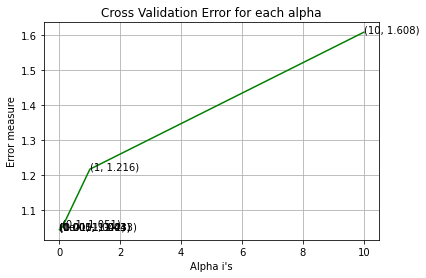

In [25]:
best_alpha = np.argmin(rmse_sgd)
print("best_alpha",best_alpha)
fig, ax = plt.subplots()
ax.plot(alpha_sgd, rmse_sgd,c='g')
for i, txt in enumerate(np.round(rmse_sgd,3)):
    ax.annotate((alpha_sgd[i],np.round(txt,3)), (alpha_sgd[i],rmse_sgd[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# ARD Regressor :

In [26]:
from sklearn.linear_model import ARDRegression

In [27]:
#https://www.kaggle.com/nsrose7224/stochastic-gradient-descent-regressor
alpha_ard = [10 ** x for x in range(-5, 2)]
rmse_ard = []
for i in tqdm(alpha_ard): 
    ard_clf = ARDRegression(n_iter=300, tol=0.001, alpha_1= i, alpha_2= 1e-05, lambda_1=1e-6, lambda_2=1e-06, compute_score=False)
    ard_clf.fit(xx_train, yy_train)
    y_pred =  ard_clf.predict(xx_valid)
    error = sqrt(mean_squared_error(yy_valid, y_pred))
    print ('rmse for alpha_1 = ',i,'is',error)
    rmse_ard.append(error)


rmse for alpha_1 =  1e-05 is 1.0410296912560568
rmse for alpha_1 =  0.0001 is 1.0410296912560588
rmse for alpha_1 =  0.001 is 1.0410296912560568
rmse for alpha_1 =  0.01 is 1.0410296912560595
rmse for alpha_1 =  0.1 is 1.041029691256064
rmse for alpha_1 =  1 is 1.0410296912561186
rmse for alpha_1 =  10 is 1.0410296912566501



best_alpha 0


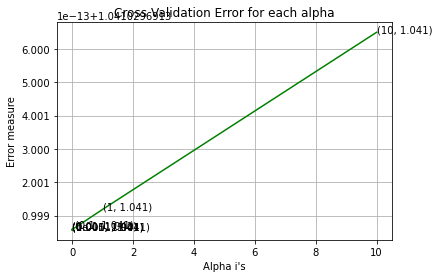

In [28]:
best_alpha = np.argmin(rmse_ard)
print("best_alpha",best_alpha)
fig, ax = plt.subplots()
ax.plot(alpha_ard, rmse_ard,c='g')
for i, txt in enumerate(np.round(rmse_ard,3)):
    ax.annotate((alpha_ard[i],np.round(txt,3)), (alpha_ard[i],rmse_ard[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# DecisionTreeRegressor :

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
max_depth_dtr = [3,5,10,50,100] 
rmse_dtr = []
for i in tqdm(max_depth_dtr):
    dtr_clf = DecisionTreeRegressor(max_depth=i)
    dtr_clf.fit(xx_train,yy_train)
    y_pred = dtr_clf.predict(xx_valid)
    error = sqrt(mean_squared_error(yy_valid, y_pred))
    rmse_dtr.append(error)
    print ('rmse for max_depth ',i,'is',error)


rmse for max_depth  3 is 1.0889306600635569
rmse for max_depth  5 is 1.0365821929830623
rmse for max_depth  10 is 0.8373526871453013
rmse for max_depth  50 is 0.8129701087072789
rmse for max_depth  100 is 0.8141675950542806



max_depth 3


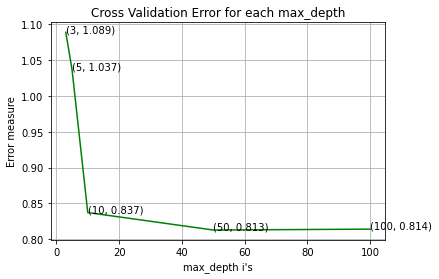

In [31]:
best_max_depth = np.argmin(rmse_dtr)
print("max_depth",best_max_depth)
fig, ax = plt.subplots()
ax.plot(max_depth_dtr, rmse_dtr,c='g')
for i, txt in enumerate(np.round(rmse_dtr,3)):
    ax.annotate((max_depth_dtr[i],np.round(txt,3)), (max_depth_dtr[i],rmse_dtr[i]))
plt.grid()
plt.title("Cross Validation Error for each max_depth")
plt.xlabel("max_depth i's")
plt.ylabel("Error measure")
plt.show()

# ElasticNet :

In [32]:
from sklearn.linear_model import ElasticNet

In [33]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
alpha_eln = [10 ** x for x in range(-5, 2)]
rmse_eln = []
for i in tqdm(alpha_eln): 
    eln_clf = ElasticNet(alpha= i , l1_ratio=0.5)
    eln_clf.fit(xx_train, yy_train)
    y_pred =  eln_clf.predict(xx_valid)
    error = sqrt(mean_squared_error(yy_valid, y_pred))
    print ('rmse for alpha_1 = ',i,'is',error)
    rmse_eln.append(error)


rmse for alpha_1 =  1e-05 is 1.0410941762319337
rmse for alpha_1 =  0.0001 is 1.0410726089128657
rmse for alpha_1 =  0.001 is 1.040984568053859
rmse for alpha_1 =  0.01 is 1.0403567276949972
rmse for alpha_1 =  0.1 is 1.0504585015433145
rmse for alpha_1 =  1 is 1.3236307107197975
rmse for alpha_1 =  10 is 1.777608077558771



best_alpha 3


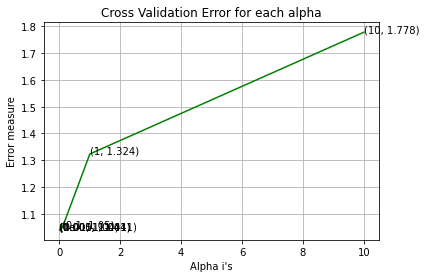

In [34]:
best_alpha = np.argmin(rmse_eln)
print("best_alpha",best_alpha)
fig, ax = plt.subplots()
ax.plot(alpha_eln, rmse_eln,c='g')
for i, txt in enumerate(np.round(rmse_eln,3)):
    ax.annotate((alpha_eln[i],np.round(txt,3)), (alpha_eln[i],rmse_eln[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# XGBRegressor :

In [30]:
from xgboost import XGBRegressor

In [ ]:
#est_xgb = [20,50,100,200] 
max_depth_xgb= [3,5,9,13,21] 
rmse_xgb = []
for i in tqdm(max_depth_xgb):
    xgb_clf =XGBRegressor(n_estimators=50,max_depth = i,nthread=-1,verbose = 1)
    xgb_clf.fit(xx_train,yy_train)
    y_pred =  xgb_clf.predict(xx_valid)
    error = sqrt(mean_squared_error(yy_valid, y_pred))
    rmse_xgb.append(error)
    print ('rmse for estimators = ',i,'is',error)


[11:09:34] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:09:35] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
rmse for estimators =  3 is 0.8679099295640513
[11:40:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:40:05] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method 

In [ ]:
best_est = np.argmin(rmse_xgb)
print("best_alpha",best_est)
fig, ax = plt.subplots()
ax.plot(max_depth_xgb, rmse_xgb,c='g')
for i, txt in enumerate(np.round(rmse_xgb,3)):
    ax.annotate((max_depth_xgb[i],np.round(txt,3)), (max_depth_xgb[i],rmse_xgb[i]))
plt.grid()
plt.title("Cross Validation Error for number of estimators")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# Random forest regressor :

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
##### https://www.kaggle.com/c/datasciencebowl/discussion/12520
#estimators = [16,32,64,128]
max_depth_rfr = [3,5,7,11] 
rmse_rfr = []
for i in tqdm(max_depth_rfr):
    rfr_clf =RandomForestRegressor(n_estimators=50,max_depth = i,n_jobs= 4,verbose=1)#n_jobs=-1,
    rfr_clf.fit(xx_train,yy_train)
    y_pred =  rfr_clf.predict(xx_valid)
    error = sqrt(mean_squared_error(yy_valid, y_pred))
    rmse_rfr.append(error)
    print ('rmse for each max_depth = ',i,'is',error)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 11.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.0s finished


rmse for each max_depth =  3 is 1.0873516179452936


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 17.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 19.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.0s finished


rmse for each max_depth =  5 is 1.0352048735428592


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 26.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 30.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.4s finished


rmse for each max_depth =  7 is 0.9682190595883137


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 37.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 42.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s


rmse for each max_depth =  11 is 0.7701294878255439



[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.3s finished


3


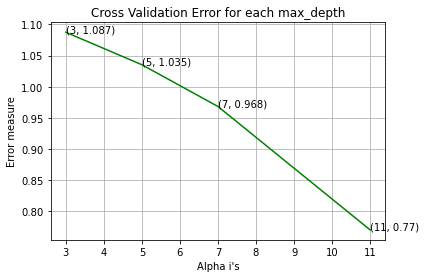

In [25]:
best_alpha = np.argmin(rmse_rfr)
print(best_alpha)
fig, ax = plt.subplots()
ax.plot(max_depth_rfr, rmse_rfr,c='g')
for i, txt in enumerate(np.round(rmse_rfr,3)):
    ax.annotate((max_depth_rfr[i],np.round(txt,3)), (max_depth_rfr[i],rmse_rfr[i]))
plt.grid()
plt.title("Cross Validation Error for each max_depth")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# LGBM :

In [21]:
import lightgbm as lgb

In [22]:

alpha_lgb=[25,50,150,500,1000]
#alpha_lgb=[500]
rmse_lgb = []
for i in tqdm(alpha_lgb):
    lgb_clf=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i, objective='regression', n_jobs=-1)
    model = lgb_clf.fit(xx_train,yy_train)
    y_pred =  model.predict(xx_valid)
    error = sqrt(mean_squared_error(yy_valid, y_pred))
    rmse_lgb.append(error)
    print ('rmse for estimators = ',i,'is',error)



rmse for estimators =  25 is 0.8789424524547844
rmse for estimators =  50 is 0.7707259931163246
rmse for estimators =  150 is 0.7079671301058731
rmse for estimators =  500 is 0.6568662420866657
rmse for estimators =  1000 is 0.6343791253819746



In [23]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))


#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

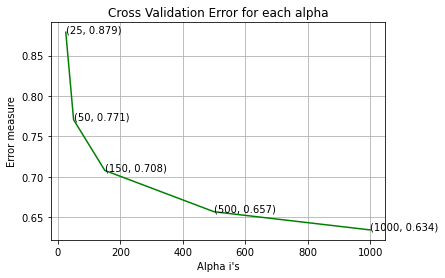

In [24]:

best_alpha = np.argmin(rmse_lgb)

fig, ax = plt.subplots()
ax.plot(alpha_lgb, rmse_lgb,c='g')
for i, txt in enumerate(np.round(rmse_lgb,3)):
    ax.annotate((alpha_lgb[i],np.round(txt,3)), (alpha_lgb[i],rmse_lgb[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# Deep Learning  :

In [21]:
from keras import backend
backend.clear_session()
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [22]:
print(xx_train.shape)
print(xx_valid.shape)
print(yy_train.shape)
print(yy_valid.shape)

(13673341, 24)
(4557780, 24)
(13673341,)
(4557780,)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras import backend as K


model = Sequential()
model.add(Dense(512, input_shape=(xx_train.shape[1],), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='linear'))
    
    
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model.compile(optimizer = 'adam', loss = root_mean_squared_error)




In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               12800     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4

In [25]:
n_epochs = 25
model.fit(xx_train,yy_train, epochs = n_epochs,batch_size=2048,verbose = 1,validation_data=(xx_valid,yy_valid))


Epoch 1/25
6677/6677 [==============================] - 25s 4ms/step - loss: 0.7614 - val_loss: 0.7646
Epoch 2/25
6677/6677 [==============================] - 25s 4ms/step - loss: 0.6286 - val_loss: 0.7214
Epoch 3/25
6677/6677 [==============================] - 24s 4ms/step - loss: 0.5977 - val_loss: 0.7167
Epoch 4/25
6677/6677 [==============================] - 26s 4ms/step - loss: 0.5823 - val_loss: 0.7157
Epoch 5/25
6677/6677 [==============================] - 24s 4ms/step - loss: 0.5726 - val_loss: 0.7156
Epoch 6/25
6677/6677 [==============================] - 25s 4ms/step - loss: 0.5656 - val_loss: 0.7192
Epoch 7/25
6677/6677 [==============================] - 25s 4ms/step - loss: 0.5604 - val_loss: 0.7101
Epoch 8/25
6677/6677 [==============================] - 24s 4ms/step - loss: 0.5558 - val_loss: 0.7118
Epoch 9/25
6677/6677 [==============================] - 25s 4ms/step - loss: 0.5522 - val_loss: 0.7241
Epoch 10/25
6677/6677 [==============================] - 24s 4ms/step - l

# Summary :

1. Creating train and valid set from data and adding new features for better performance of models.
2. I tried different Regression models to check which model performs well for given data.
3. Performing simple baseline model to know the limit of rmse, which turns out to be 1.71
3. Sgd , ard, elasticnet regressor are performing at same level and rmse of these models is around 1.04
4. Random Forest and decision tree regressors are performing better than linear models , rmse of these models is around 0.81
5. LGBM,XGB and deep learning model are performing way better than other models and rmse is around 0.7
6. LGBM and deep learning model are faster compared to XGB